In [1]:
# 导入所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

import warnings
warnings.filterwarnings('ignore')


In [2]:
# 导入数据
data = pd.read_csv('./iBite_table.csv')

# 选择所需的列
data = data[['infraclass', 'cohort', 'order', 'suborder', 'superfamily', 'family', 'subfamily', 'tribe', 'genus', 'species',
             'iBite', 'ID', 'specimen', 'amplification',
             'head.w', 'head.h', 'head.l', 'th.w', 'body.l', 'wing.l',
             'latitude', 'longitude', 'country']]

# 删除缺失经纬度的行
data = data.dropna(subset=['latitude', 'longitude'])

# 查看数据概况
print("数据预览：")
print(data.head())

print("\n数据缺失值统计：")
print(data.isnull().sum())


数据预览：
   infraclass        cohort      order suborder  superfamily      family  \
11   Neoptera  Polyneoptera  Blattodea        -  Blaberoidea  Blaberidae   
12   Neoptera  Polyneoptera  Blattodea        -  Blaberoidea  Blaberidae   
13   Neoptera  Polyneoptera  Blattodea        -  Blaberoidea  Blaberidae   
14   Neoptera  Polyneoptera  Blattodea        -  Blaberoidea  Blaberidae   
31   Neoptera  Polyneoptera  Blattodea        -  Blaberoidea  Blaberidae   

        subfamily      tribe         genus       species  ...  amplification  \
11  Diplopterinae          -    Calolampra       sp_AUS1  ...            2.0   
12  Diplopterinae          -    Calolampra       sp_AUS1  ...            2.0   
13   Epilamprinae          -  Rhabdoblatta       sp_AUS2  ...            2.0   
14   Epilamprinae  Morphnini  Rhabdoblatta       sp_AUS1  ...            2.0   
31  Pycnoscelinae          -   Pycnoscelus  surinamensis  ...            2.0   

   head.w head.h  head.l  th.w  body.l  wing.l   latitud

In [3]:
# 定义需要进行 One-Hot 编码的列（低基数）
categorical_cols = ['order', 'family', 'subfamily']

# 对分类变量进行 One-Hot 编码
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 对高基数分类变量进行标签编码或忽略
from sklearn.preprocessing import LabelEncoder

high_cardinality_cols = ['genus', 'species']

for col in high_cardinality_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))


In [4]:
# 生成组合特征
data_encoded['head_w_body_l_ratio'] = data_encoded['head.w'] / data_encoded['body.l']
data_encoded['head_volume'] = data_encoded['head.w'] * data_encoded['head.h'] * data_encoded['head.l']
data_encoded['wing_body_ratio'] = data_encoded['wing.l'] / data_encoded['body.l']

# 填充可能的无穷值和缺失值
data_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
data_encoded.fillna(0, inplace=True)


In [5]:
# 创建 GeoDataFrame
geometry = [Point(xy) for xy in zip(data_encoded['longitude'], data_encoded['latitude'])]
geo_data = gpd.GeoDataFrame(data_encoded, geometry=geometry, crs='EPSG:4326')

# 转换为投影坐标系（例如：World Mercator EPSG:3857）
geo_data = geo_data.to_crs(epsg=3857)
geo_data['x'] = geo_data.geometry.x
geo_data['y'] = geo_data.geometry.y


In [6]:
# 数值特征列
numeric_features = ['head.w', 'head.h', 'head.l', 'th.w', 'body.l', 'wing.l',
                    'head_w_body_l_ratio', 'head_volume', 'wing_body_ratio', 'x', 'y',
                    'genus', 'species']

# 提取特征
X = geo_data[numeric_features + list(geo_data.columns[geo_data.columns.str.startswith(('order_', 'family_', 'subfamily_'))])]

# 提取目标变量
y = geo_data['iBite']


In [7]:
# 对数值特征进行标准化
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])


In [8]:
# 定义模型
rf = RandomForestRegressor(random_state=42)

# 使用 RFECV 进行特征选择
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 进行特征选择
rfecv.fit(X, y)

print(f"最优特征数量：{rfecv.n_features_}")
selected_features = X.columns[rfecv.support_]
# selected_features = ['head.w', 'head.h', 'head.l', 'th.w', 'body.l', 'wing.l', 'x', 'y']
print(f"选中的特征：{selected_features}")


最优特征数量：3
选中的特征：Index(['th.w', 'x', 'y'], dtype='object')


In [9]:
# 划分数据集（训练集：80%，测试集：20%）
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)


In [10]:
X_train

,th.w,x,y
335,-0.183784,1.423514,-1.202501
911,0.148026,1.425059,-1.209385
1796,-0.234832,-0.279121,1.009368
393,-0.434768,-0.278054,1.010346
1032,0.462819,-0.279736,0.954891
...,...,...,...
1613,-1.191975,-0.278948,1.008963
1680,-0.898451,-1.351139,-0.460064
1844,-0.694261,-0.279657,1.006395
1363,1.466757,-0.279110,1.009377


In [11]:
# 定义模型和参数网格
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=0),
    'SVR': SVR(),
    'GPR': GaussianProcessRegressor()
}

params = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.05],
        'subsample': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'learning_rate': [0.1, 0.05],
        'num_leaves': [31, 50],
        'min_child_samples': [1, 5]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'depth': [6, 8],
        'learning_rate': [0.1, 0.05]
    },
    'SVR': {
        'kernel': ['rbf'],
        'C': [1, 10],
        'gamma': ['scale', 'auto']
    },
    'GPR': {
        'kernel': [C(1.0) * RBF(length_scale=1.0)],
        'alpha': [1e-10, 1e-5]
    }
}


In [12]:
from sklearn.model_selection import GridSearchCV

best_estimators = {}
results = []

for name in models.keys():
    print(f"正在训练和调优模型：{name}")
    model = models[name]
    param_grid = params[name]
    if param_grid:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"最佳参数：{grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_model = model
    best_estimators[name] = best_model

    # 在测试集上评估模型
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MSE': mse, 'R2': r2})
    print(f"{name} 测试集 MSE: {mse:.2f}, R2: {r2:.2f}\n")


正在训练和调优模型：RandomForest
最佳参数：{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RandomForest 测试集 MSE: 242062.28, R2: 0.53

正在训练和调优模型：XGBoost
最佳参数：{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
XGBoost 测试集 MSE: 232875.17, R2: 0.55

正在训练和调优模型：LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 3
[LightGBM] [Info] Start training from score 1370.918396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 3
[LightGBM] [Info]

/opt/anaconda3/envs/comp7811/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/comp7811/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/comp7811/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/comp7811


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/envs/comp7811/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/envs/comp7811/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/comp7811/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warn

最佳参数：{'alpha': 1e-05, 'kernel': 1**2 * RBF(length_scale=1)}
GPR 测试集 MSE: 1160655.34, R2: -1.26



In [13]:
results_df = pd.DataFrame(results)
print("模型性能比较：")
print(results_df)

模型性能比较：
          Model           MSE        R2
0  RandomForest  2.420623e+05  0.527875
1       XGBoost  2.328752e+05  0.545794
2      LightGBM  2.349170e+05  0.541811
3      CatBoost  2.278176e+05  0.555658
4           SVR  5.071255e+05  0.010888
5           GPR  1.160655e+06 -1.263775


In [14]:
# 找到 R2 最高的模型
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
print(f"性能最优的模型是：{best_model_name}")

# 获取最优模型
final_model = best_estimators[best_model_name]


性能最优的模型是：CatBoost


  Feature  Importance
2       y   47.770076
1       x   34.225416
0    th.w   18.004508


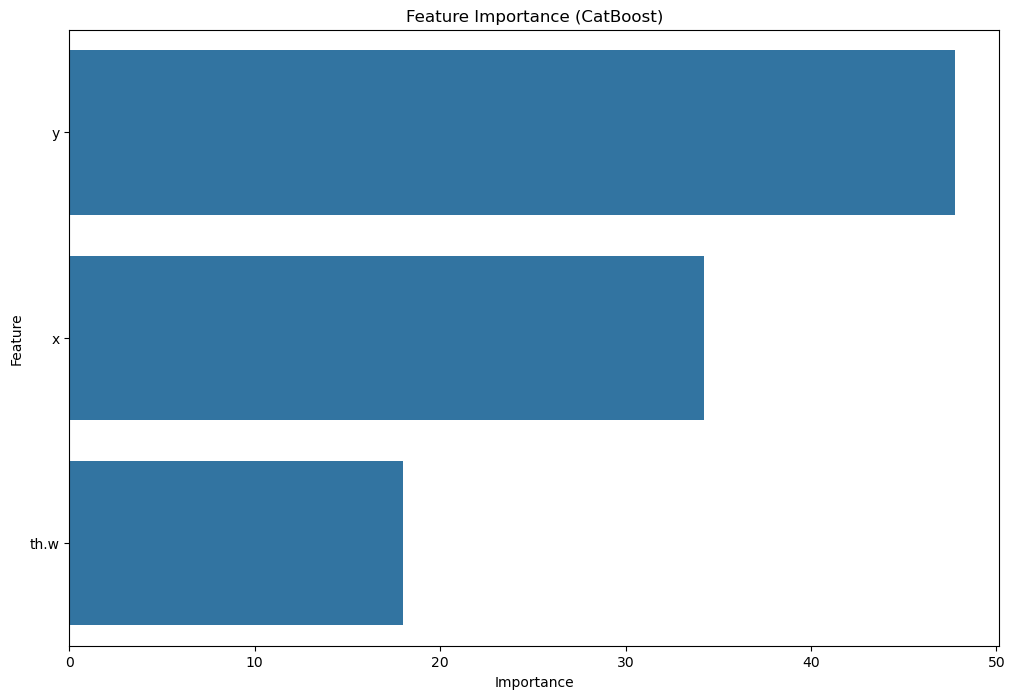

In [15]:
if best_model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']:
    # 输出特征重要性
    importances = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print(feature_importance_df)
    
    # 可视化特征重要性
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance ({best_model_name})')
    plt.show()


In [16]:
import shap

if best_model_name in ['RandomForest', 'XGBoost', 'LightGBM']:
    # 计算 SHAP 值
    explainer = shap.Explainer(final_model, X_train)
    shap_values = explainer(X_test)
    
    # 可视化整体特征重要性
    shap.summary_plot(shap_values, X_test, feature_names=selected_features)


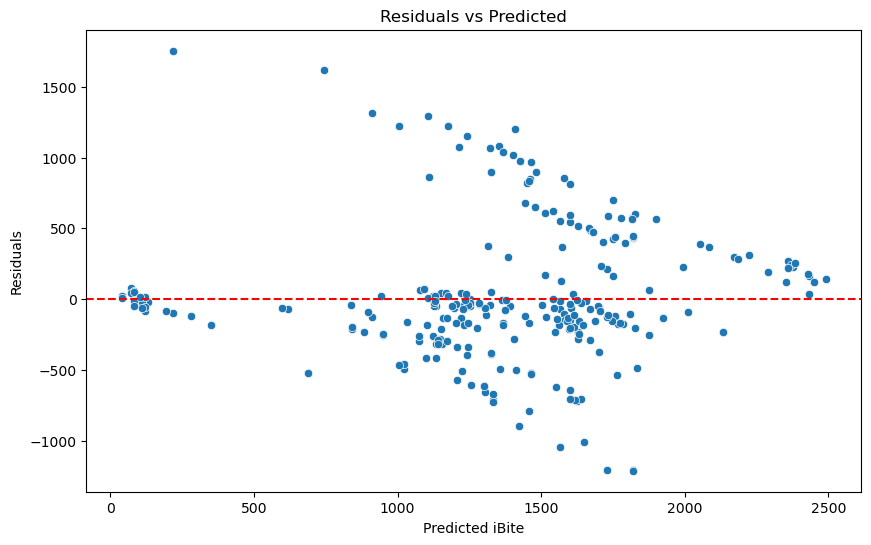

In [17]:
# 预测结果
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred

# 绘制残差图
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted iBite')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


In [18]:
print(geo_data.index)
print(y_test.index)


Index([  11,   12,   13,   14,   31,   32,   33,   34,   35,   46,
       ...
       1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905],
      dtype='int64', length=1355)
Index([ 330, 1614,  934, 1628, 1425, 1198,  574, 1447, 1137, 1091,
       ...
       1136,  869, 1451,  570,  683, 1522, 1553, 1835, 1806, 1401],
      dtype='int64', length=271)


In [19]:
from esda import Moran
from libpysal.weights import KNN

# 将残差添加到 GeoDataFrame 中
# test_geo_data = geo_data.iloc[y_test.index]
# 重新对齐 geo_data 的索引以匹配 y_test 的索引
test_geo_data = geo_data.reindex(y_test.index).copy()

# 将残差添加到 GeoDataFrame 中
test_geo_data['residuals'] = residuals.values

# 计算空间权重矩阵
w = KNN.from_dataframe(test_geo_data, k=3)
w.transform = 'R'

# 计算莫兰指数
moran = Moran(test_geo_data['residuals'], w)
print(f"Moran's I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")


Moran's I: -0.0081, p-value: 0.4690


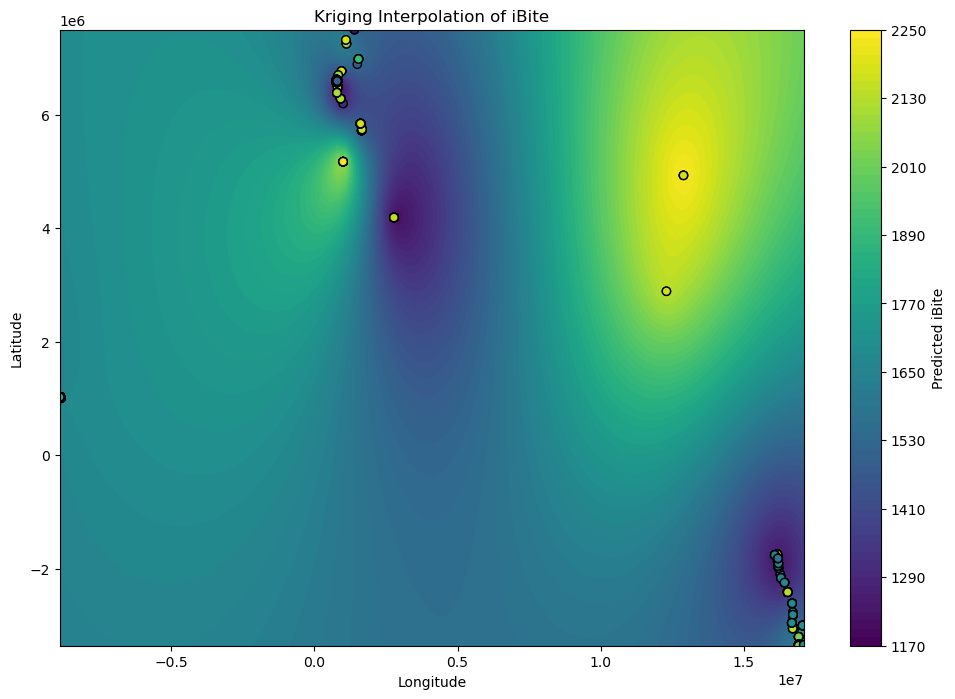

In [20]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

# 准备数据
longitude = geo_data['geometry'].x.values
latitude = geo_data['geometry'].y.values
values = geo_data['iBite'].values

# 创建 Kriging 对象
OK = OrdinaryKriging(longitude, latitude, values, variogram_model='linear', verbose=False, enable_plotting=False)

# 定义网格范围
gridx = np.linspace(longitude.min(), longitude.max(), 100)
gridy = np.linspace(latitude.min(), latitude.max(), 100)

# 执行插值
z, ss = OK.execute('grid', gridx, gridy)

# 可视化插值结果
plt.figure(figsize=(12, 8))
plt.contourf(gridx, gridy, z, levels=100, cmap='viridis')
plt.colorbar(label='Predicted iBite')
plt.scatter(longitude, latitude, c=values, edgecolor='k', cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Kriging Interpolation of iBite')
plt.show()


In [21]:
import joblib

# 保存模型
model_filename = f'best_model_{best_model_name}.pkl'
joblib.dump(final_model, model_filename)
print(f"最优模型已保存为 {model_filename}")


最优模型已保存为 best_model_CatBoost.pkl


总结与下一步工作
通过引入更多的模型，我们比较了多种机器学习方法的性能。根据模型的表现，可以选择最优的模型进行进一步的分析和预测。

下一步建议：

深入调优最优模型的参数：可以尝试更多的参数组合，使用更细致的网格搜索或随机搜索。
结合领域知识：分析特征的重要性和模型的预测结果，结合昆虫学的知识，解释结果的生物学意义。
部署模型：将模型部署到生产环境中，或者开发一个应用程序，用于预测新的数据。